In [0]:
import tensorflow as tf

In [0]:
# more imports 
# layers
from tensorflow.keras.layers import Input, Dense, Flatten
# pretrained model
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
# model
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers import SGD, Adam
# preprocessing tools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [0]:
import tensorflow as tf

In [0]:
# More imports

# layers
from tensorflow.keras.layers import Input, Dense, Flatten
# import pretrained model for transfer learning
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
# model 
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers import SGD, Adam
# preprocessing tools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# glob
from glob import glob

# additional imports
import numpy as np # linear algebra
import pandas as pd # data manipulation 
import matplotlib.pyplot as plt # data visualisation
import sys, os # wut ?!

In [0]:
# Data source : https://mmspg.epfl.ch/downloads/food-image-datasets/
# download the dataset through FTP
# its a binary classification dataset that contains food images and the images that aren't food
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-04-14 21:41:38--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  85.7MB/s    in 5.0s    

2020-04-14 21:41:43 (86.1 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [0]:
!unzip -qq -o Food-5K.zip

In [0]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [0]:
!ls Food-5K

evaluation  training  validation


In [0]:
!ls Food-5K/training

In [0]:
# so the data format is {label}_{image_id}.jpg
# 0 is for the ones that doesn't contain any food
# and 1 is for the food photos
# let's take a look to random sample
PATH = 'Food-5K/'
plt.imshow(image.load_img(PATH + "training/1_404.jpg"))
plt.show()
plt.imshow(image.load_img(PATH + "training/0_808.jpg"))
plt.show()

In [0]:
!mkdir data

In [0]:
# Make directories to store the data as Keras-style which as the following:
# data
#  - train
#     - class1
#     - class2
#     .
#     .
#     .
#  - validation
#     - class1
#     - class2
#     .
#     .
#     .
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [0]:
# Move the images
# Note: we will consider 'training to be the train set
#       'validation' folder will be the test set
#       ignore 'evaluation' set
# well we can combine the evaluation set with any other folders
# but the file names would conflict so it may be harder to prepare it
!mv Food-5K/training/0*.jpg data/train/nonfood
!mv Food-5K/training/1*.jpg data/train/food
!mv Food-5K/validation/0*.jpg data/test/nonfood
!mv Food-5K/validation/1*.jpg data/test/food

In [0]:
train_path = 'data/train'
valid_path = 'data/test'

In [0]:
# These images are pretty big and of different sizes
# let's load them all in as the same (smaller) size
IMAGE_SIZE = [224, 224]

In [0]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [0]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

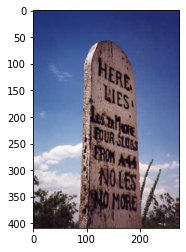

In [0]:
# lets pick an image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [0]:
# input_shape = IMAGE_SIZE + [3] since we have 3 more value for RGB channels
# weights = 'imagenet' so the model downloads pretrained weights from 
# vgg trained on a imagenet dataset
# include_top = False because instead of getting full VGG network
# we just get everything from bottom to the final convolution
# and excluding the last (head) layer. 
# There is no flatten and none of the final dense layers
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet',
    include_top = False)

58892288/58889256 [==============================] - 0s 0us/step


In [0]:
# map the data into feature vectors
x = Flatten()(ptm.output)

In [0]:
model = Model(inputs=ptm.input, outputs = x)

In [0]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# create an instance of ImageDataGenerator
# we won't use data augmentation
gen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [0]:
batch_size = 128

# create generators
# we don't need to shuffle the training data because all we do is transforming it
# also we're passing class mode argument to specify that our targets are binary
# so there's no need to one-hot encode them
# if we pass 'sparse', this will also return a one dimensional array of integer
# classes rather than one-hot encoding
train_generator = gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode = 'binary', 
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode = 'binary',
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# now we're going to work on creating our tabular dataset 
# consisting of transforms the features from the original data
# once we have this we are no longer working with the original dataset
# so first we're going to set number of files to Ntrain and Nvalid
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

# Figure out the output size
# The second dimension of the output is feature dimensionality
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

# 
X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

In [0]:
# populate X_train and Y_train
i = 0 # will tell us which sample we currently populating
for x, y in train_generator:
  # get features
  features = model.predict(x)

  # size of the batch (may not always be batch_size)
  sz = len(y)

  # assign to X_train and Y_train
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y

  # increment i
  i += sz
  
  print(i)
  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [0]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)

  # size of the batch (there may be batches that has different sizes from this)
  sz = len(y)

  # assign to X_valid and Y_valid
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y

  # increment i
  i += sz

  print(i)
  if i >= Nvalid:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1000
breaking now
1000


In [0]:
# since we're using relu as activation function,
# minimum will be 0
# but maximum value is too high so we may consider to normalize the data
X_train.max(), X_train.min()

(603.938232421875, 0.0)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [0]:
# Try the built-in logistic regression
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
# print out the accuracies
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.982


In [0]:
# Do logistic regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation = 'sigmoid')(i)
linearmodel = Model(i, x)

In [0]:
linearmodel.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [0]:
# Can try both normalized and unnormalized data
r = linearmodel.fit(
    X_train, Y_train,
    batch_size = 128,
    epochs = 10,
    validation_data = (X_valid, Y_valid),
)
r_scaled = linearmodel.fit(X_train2, Y_train, batch_size = 128, epochs = 10, validation_data = (X_valid2, Y_valid))

Epoch 1/10
24/24 [==============================] - 0s 17ms/step - loss: 1.3332 - accuracy: 0.9210 - val_loss: 0.3550 - val_accuracy: 0.9750
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0927 - accuracy: 0.9930 - val_loss: 0.3326 - val_accuracy: 0.9770
Epoch 3/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0123 - accuracy: 0.9980 - val_loss: 0.2905 - val_accuracy: 0.9830
Epoch 4/10
24/24 [==============================] - 0s 12ms/step - loss: 4.3612e-05 - accuracy: 1.0000 - val_loss: 0.2928 - val_accuracy: 0.9820
Epoch 5/10
24/24 [==============================] - 0s 12ms/step - loss: 4.0174e-06 - accuracy: 1.0000 - val_loss: 0.2945 - val_accuracy: 0.9820
Epoch 6/10
24/24 [==============================] - 0s 11ms/step - loss: 3.3057e-06 - accuracy: 1.0000 - val_loss: 0.2944 - val_accuracy: 0.9820
Epoch 7/10
24/24 [==============================] - 0s 12ms/step - loss: 2.5186e-06 - accuracy: 1.0000 - val_loss: 0.2942 - val_accuracy: 0.98

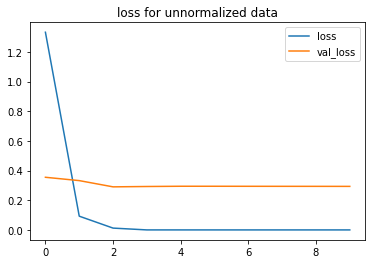

In [0]:
# loss
plt.title('loss for unnormalized data')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

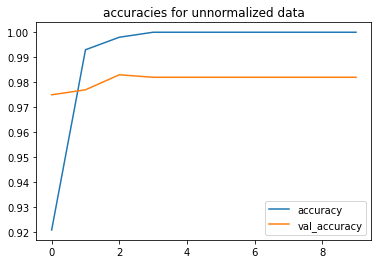

In [0]:
# accuracies
plt.title('accuracies for unnormalized data')
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

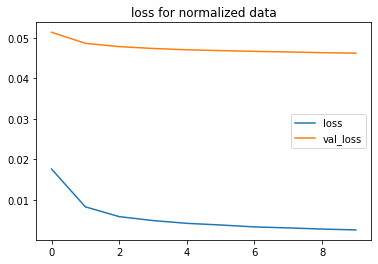

In [0]:
# loss
plt.title('loss for normalized data')
plt.plot(r_scaled.history['loss'], label = 'loss')
plt.plot(r_scaled.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

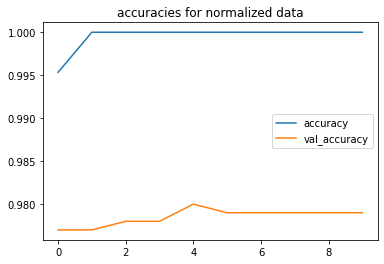

In [0]:
# accuracies
plt.title('accuracies for normalized data')
plt.plot(r_scaled.history['accuracy'], label = 'accuracy')
plt.plot(r_scaled.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()